In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as sco
import pandas_datareader as pdr

In [5]:
def getStockQuotes(symbols, source, startDate, endDate):
    quotes = pd.DataFrame()
    
    for symbol in symbols:
        quotes[symbol] = pdr.get_data_fred(symbol, data_source=source, start=startDate, end=endDate)['Adj Close']
        
    return quotes

In [6]:
def calcPortfolioPerf(weights, meanReturns, covMatrix):
    '''
    Calculates the expected mean of returns and volatility for a portolio of 
    assets, each carrying the weight specified by weights
    
    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    
    OUTPUT
    tuple containing the portfolio return and volatility
    '''    
    #Calculate return and variance
    portReturn = np.sum( meanReturns*weights )
    portStdDev = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)))
    
    return portReturn, portStdDev

In [7]:
def negSharpeRatio(weights, meanReturns, covMatrix, riskFreeRate):
    '''
    Returns the negated Sharpe Ratio for the speicified portfolio of assets
    
    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    riskFreeRate: time value of money
    '''
    p_ret, p_var = calcPortfolioPerf(weights, meanReturns, covMatrix)
    
    return -(p_ret - riskFreeRate) / p_var

In [8]:
def getPortfolioVol(weights, meanReturns, covMatrix):
    '''
    Returns the volatility of the specified portfolio of assets
    
    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    
    OUTPUT
    The portfolio's volatility
    '''
    return calcPortfolioPerf(weights, meanReturns, covMatrix)[1]

In [9]:
def findMaxSharpeRatioPortfolio(meanReturns, covMatrix, riskFreeRate):
    '''
    Finds the portfolio of assets providing the maximum Sharpe Ratio
    
    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    riskFreeRate: time value of money
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))
    
    opts = sco.minimize(negSharpeRatio, numAssets*[1./numAssets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return opts

In [10]:
def findMinVariancePortfolio(meanReturns, covMatrix):
    '''
    Finds the portfolio of assets providing the lowest volatility
    
    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))
    
    opts = sco.minimize(getPortfolioVol, numAssets*[1./numAssets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return opts

In [11]:
def findEfficientReturn(meanReturns, covMatrix, targetReturn):
    '''
    Finds the portfolio of assets providing the target return with lowest
    volatility
    
    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    targetReturn: APR of target expected return
    
    OUTPUT
    Dictionary of results from optimization
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    
    def getPortfolioReturn(weights):
        return calcPortfolioPerf(weights, meanReturns, covMatrix)[0]
    
    constraints = ({'type': 'eq', 'fun': lambda x: getPortfolioReturn(x) - targetReturn},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(numAssets))
    
    return sco.minimize(getPortfolioVol, numAssets*[1./numAssets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)

In [12]:
def findEfficientFrontier(meanReturns, covMatrix, rangeOfReturns):
    '''
    Finds the set of portfolios comprising the efficient frontier
    
    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    targetReturn: APR of target expected return
    
    OUTPUT
    Dictionary of results from optimization
    '''
    efficientPortfolios = []
    for ret in rangeOfReturns:
        efficientPortfolios.append(findEfficientReturn(meanReturns, covMatrix, ret))
        
    return efficientPortfolios

In [13]:
availStocks = ['GOOGL', 'AAPL', 'AMZN', 'MSFT', 'F', 'BMW.DE', 'TM', 'KO', 'PEP']
stocks = availStocks
#stocks = ['GOOGL', 'TM', 'KO', 'PEP']
#stocks = [availStocks[i] for i in np.random.random_integers(0,len(availStocks)-1, 3)]
numAssets = len(stocks)
source = 'yahoo'
start = '2010-01-01'
end = '2015-10-31'

In [14]:
#Retrieve data from online
#data = getStockQuotes(stocks, source, start, end)

#Load data from disk
data = pd.read_hdf('./stockData.h5', 'quotes').select(lambda x: x in stocks, 1)

#Calculate returns
riskFreeRate = 0.0021
dur = 20
numPeriodsAnnually = 252.0/dur
windowedData = data[::dur]
rets = np.log(windowedData/windowedData.shift(1))

#Calculate stock mean-variance
meanDailyReturn = rets.mean()
covariance = rets.cov()

#Create a new figure
plt.figure(figsize=(8,6))

#Run MC simulation of numPortfolios portfolios
numPortfolios = 100000
results = np.zeros((3,numPortfolios))

C:\Users\Roland.Ferrao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  """


<Figure size 576x432 with 0 Axes>

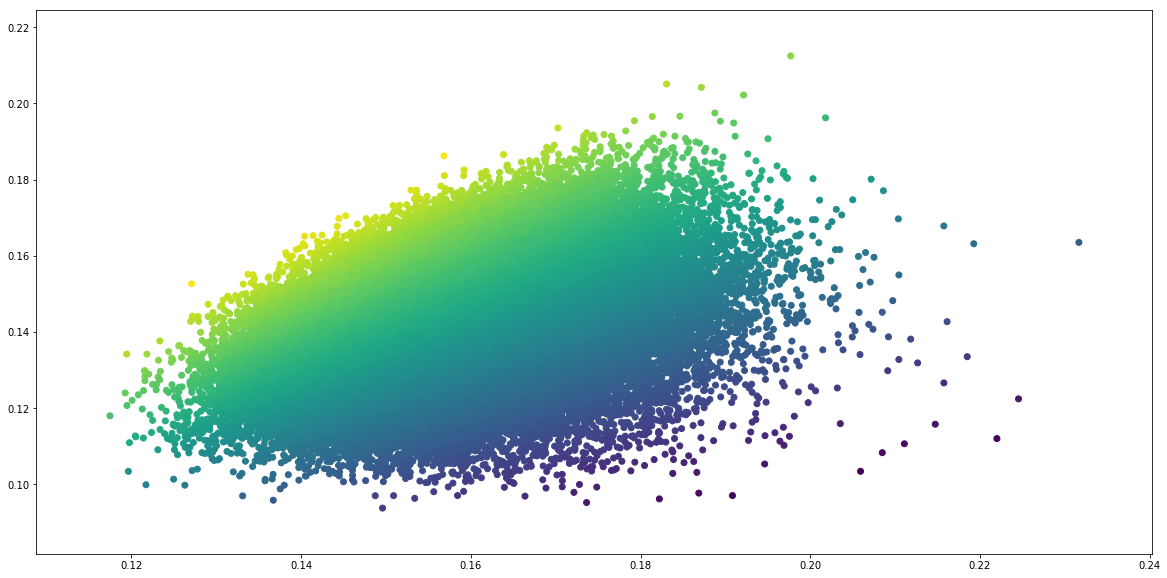

In [17]:
#Calculate portfolios
for i in range(numPortfolios):
    #Draw numAssets random numbers and normalize them to be the portfolio weights
    weights = np.random.random(numAssets)
    weights /= np.sum(weights)
    
    #Calculate expected return and volatility of portfolio
    pret, pvar = calcPortfolioPerf(weights, meanDailyReturn, covariance)
    
    #Convert results to annual basis, calculate Sharpe Ratio, and store them
    results[0,i] = pret*numPeriodsAnnually
    results[1,i] = pvar*np.sqrt(numPeriodsAnnually)
    results[2,i] = (results[0,i] - riskFreeRate)/results[1,i]
    
#Plot results of MC on portfolio weights
plt.figure(figsize = (20,10))
plt.scatter(results[1,:], results[0,:], c=results[2,:], marker='o')

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

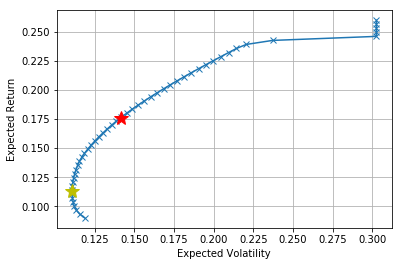

In [18]:
#Find efficient frontier, annual target returns of 9% and 16% are converted to
#match period of mean returns calculated previously
targetReturns = np.linspace(0.09, 0.26, 50)/(252./dur)
efficientPortfolios = findEfficientFrontier(meanDailyReturn, covariance, targetReturns)
plt.plot([p['fun']*np.sqrt(numPeriodsAnnually) for p in efficientPortfolios], targetReturns*numPeriodsAnnually, marker='x')

#Find portfolio with maximum Sharpe ratio
maxSharpe = findMaxSharpeRatioPortfolio(meanDailyReturn, covariance, riskFreeRate)
rp, sdp = calcPortfolioPerf(maxSharpe['x'], meanDailyReturn, covariance)
plt.plot(sdp*np.sqrt(numPeriodsAnnually), rp*numPeriodsAnnually, 'r*', markersize=15.0)

#Find portfolio with minimum variance
minVar = findMinVariancePortfolio(meanDailyReturn, covariance)
rp, sdp = calcPortfolioPerf(minVar['x'], meanDailyReturn, covariance)
plt.plot(sdp*np.sqrt(numPeriodsAnnually), rp*numPeriodsAnnually, 'y*', markersize=15.0)
    
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Portfolios of Many Assets')
plt.tight_layout()
plt.savefig('Monte Carlo Simulation for Portfolio', dpi=100)

plt.figure(figsize=(20,10))
ind = np.arange(numAssets)
width = 0.35
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(ind, maxSharpe['x'], width, color='r', alpha=0.75)
rects2 = ax.bar(ind + width, minVar['x'], width, color='b', alpha=0.75)
ax.set_ylabel('Weight of Asset in Portfolio')
ax.set_ylim(0,0.6)
ax.set_title('Comparison of Portfolio Compositions')
ax.set_xticks(ind + width)
ax.set_xticklabels(stocks)
plt.tight_layout()
ax.legend((rects1[0], rects2[0]), ('Max Sharpe Ratio', 'Minimum Volatility'))
plt.savefig('Portfolio Compositions', dpi=100)
plt.show()